#Importing Libs and Dataset

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [ ]:
# Apple.Inc Stock Data

import yfinance as yf
from datetime import date, timedelta, datetime

end_date = date.today().strftime("%Y-%m-%d") #end date for our data retrieval will be current date
start_date = '1990-01-01' # Beginning date for our historical data retrieval

df = yf.download('AAPL', start=start_date, end=end_date)# fetch the data


[*********************100%%**********************]  1 of 1 completed


#Data Preprocessing

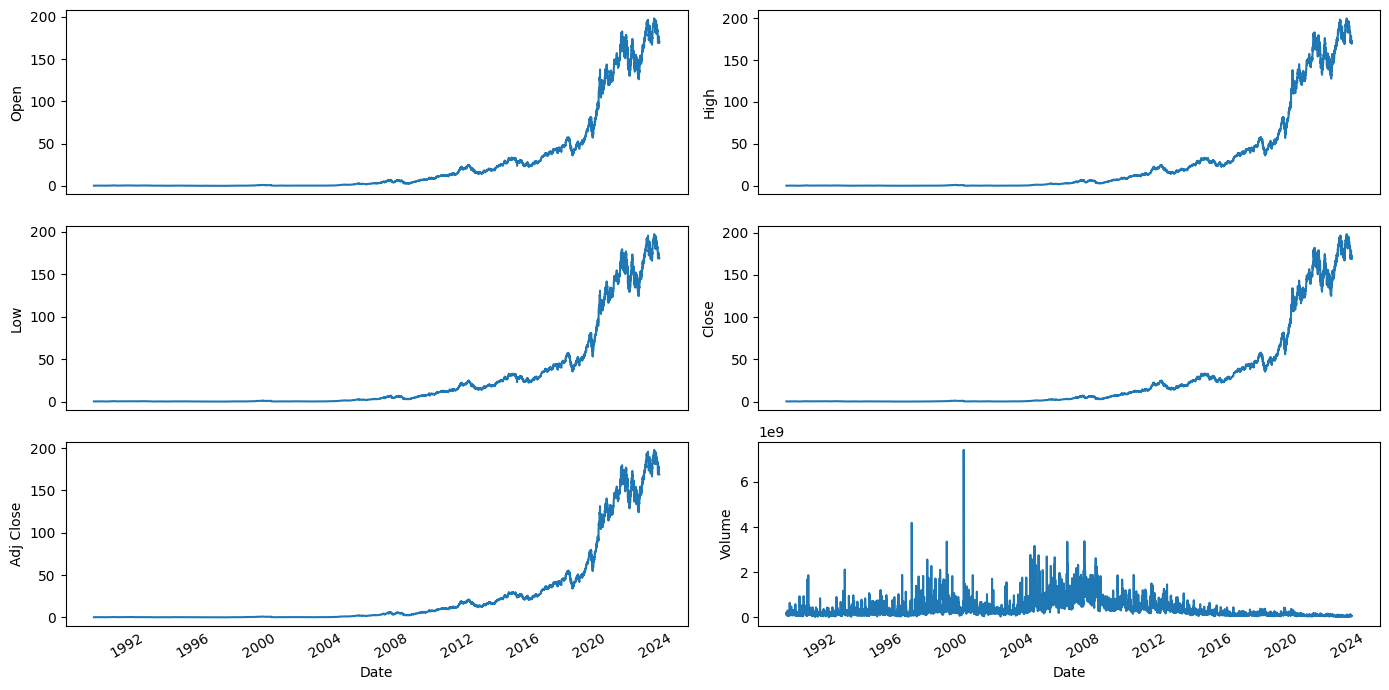

In [ ]:
def data_plot(df):
  df_plot = df.copy()

  ncols = 2
  nrows = int(round(df_plot.shape[1] / ncols, 0))

  fig, ax = plt.subplots(nrows=nrows , ncols=ncols,
                         sharex=True, figsize=(14,7))
  for i, ax in enumerate(fig.axes):
    sns.lineplot(data=df_plot.iloc[:,i],ax=ax)
    ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

  fig.tight_layout()
  plt.show()

data_plot(df)

In [ ]:
training_data_len = math.ceil(len(df) * .8)
training_data_len

train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(6904, 1) (1726, 1)


reshaping data into the necessary 2D format for use in a neural network.

In [ ]:
ds_train = train_data.Open.values
# Reshaping 1D to 2D array
ds_train = np.reshape(ds_train , (-1,1))
ds_train.shape

(6904, 1)

In [ ]:
ds_test = test_data.Open.values
ds_test = np.reshape(ds_test, (-1,1))
ds_test.shape

(1726, 1)

##Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

scaled_train = scaler.fit_transform(ds_train)
print(scaled_train[:5])

scaled_test = scaler.fit_transform(ds_test)
print(scaled_train[:5])

[[0.0051373 ]
 [0.00576871]
 [0.00582611]
 [0.00571132]
 [0.00565389]]
[[0.0051373 ]
 [0.00576871]
 [0.00582611]
 [0.00571132]
 [0.00565389]]


##Transforming the data into Sequence
We prepare the training and testing data for a neural network by generating sequences of a given length and their related labels. It then converts these sequences to NumPy arrays and PyTorch tensors.

In [ ]:
from re import X
seq_length = 50
X_train , y_train = [] , []
for i in range(len(scaled_train) - seq_length):
  X_train.append(scaled_train[i:i+seq_length])
  y_train.append(scaled_train[i+1:i+seq_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape



(torch.Size([6854, 50, 1]), torch.Size([6854, 50, 1]))

In [ ]:
seq_length = 30
X_test , y_test = [] , []
for i in range(len(scaled_train) - seq_length):
  X_test.append(scaled_train[i:i+seq_length])
  y_test.append(scaled_train[i+1:i+seq_length+1])
X_train, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape,y_test.shape

(torch.Size([6874, 30, 1]), torch.Size([6874, 30, 1]))

To make the sequences compatible with our deep learning model, the data was subsequently transformed into NumPy arrays and PyTorch tensors.

#Define LSTM class model

In [ ]:
class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units
      # num_layers : number of LSTM layers
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x): # defines forward pass of the neural network
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [ ]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


#Creating Data Loader

In [ ]:
batch_size = 16
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for batch training
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#Model Training & Evaluations


In [ ]:
num_epochs = 50
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0

    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    # Validation on test data
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        # Calculate average test loss and accuracy
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [10/50] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [20/50] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [30/50] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [40/50] - Training Loss: 0.0000, Test Loss: 0.0000
Epoch [50/50] - Training Loss: 0.0000, Test Loss: 0.0000


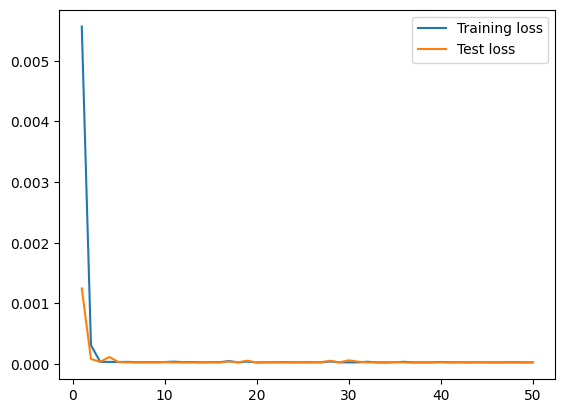

In [ ]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

#Forecasting

In [ ]:
num_forecast_steps = 30

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()

# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]
print(historical_data.shape)

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value[0])

        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value


# Generate futute dates
last_date = test_data.index[-1]

# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

# Concatenate the original index with the future dates
combined_index = test_data.index.append(future_dates)

(30,)


<ipython-input-34-c8f3706f18b6>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


#Plotting the Prediction Graph

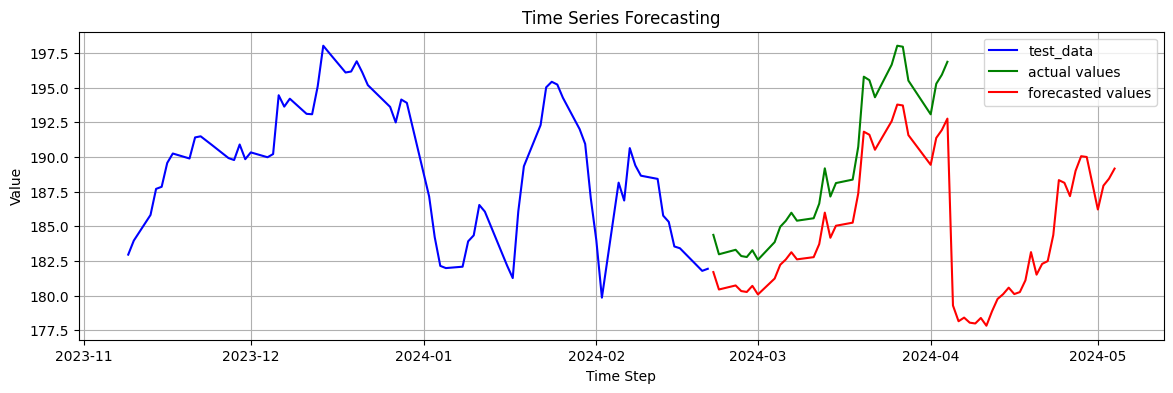

In [ ]:
plt.rcParams['figure.figsize'] = [14, 4]


#Test data
plt.plot(test_data.index[-100:-30], test_data.Open[-100:-30], label = "test_data", color = "b")
#reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten()

#the historical data used as input for forecasting
plt.plot(test_data.index[-30:], original_cases, label='actual values', color='green')

#Forecasted Values
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()
# plotting the forecasted values
plt.plot(combined_index[-60:], forecasted_cases, label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)

By plotting the test data, actual values and model’s forecasting data. We got a clear idea of how well the forecasted values are aligning with the actual time series.